In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from common_dse import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data, sharpe_ratio

In [3]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    }
]

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp() #Timezone Awareness: datetime.fromisoformat('2023-08-01') creates 
# a naive datetime (no timezone information). This means the timestamp() method will assume 
# this time is in your local system's timezone.
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market) # read from './data/{exchange}_{market}.csv'
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())



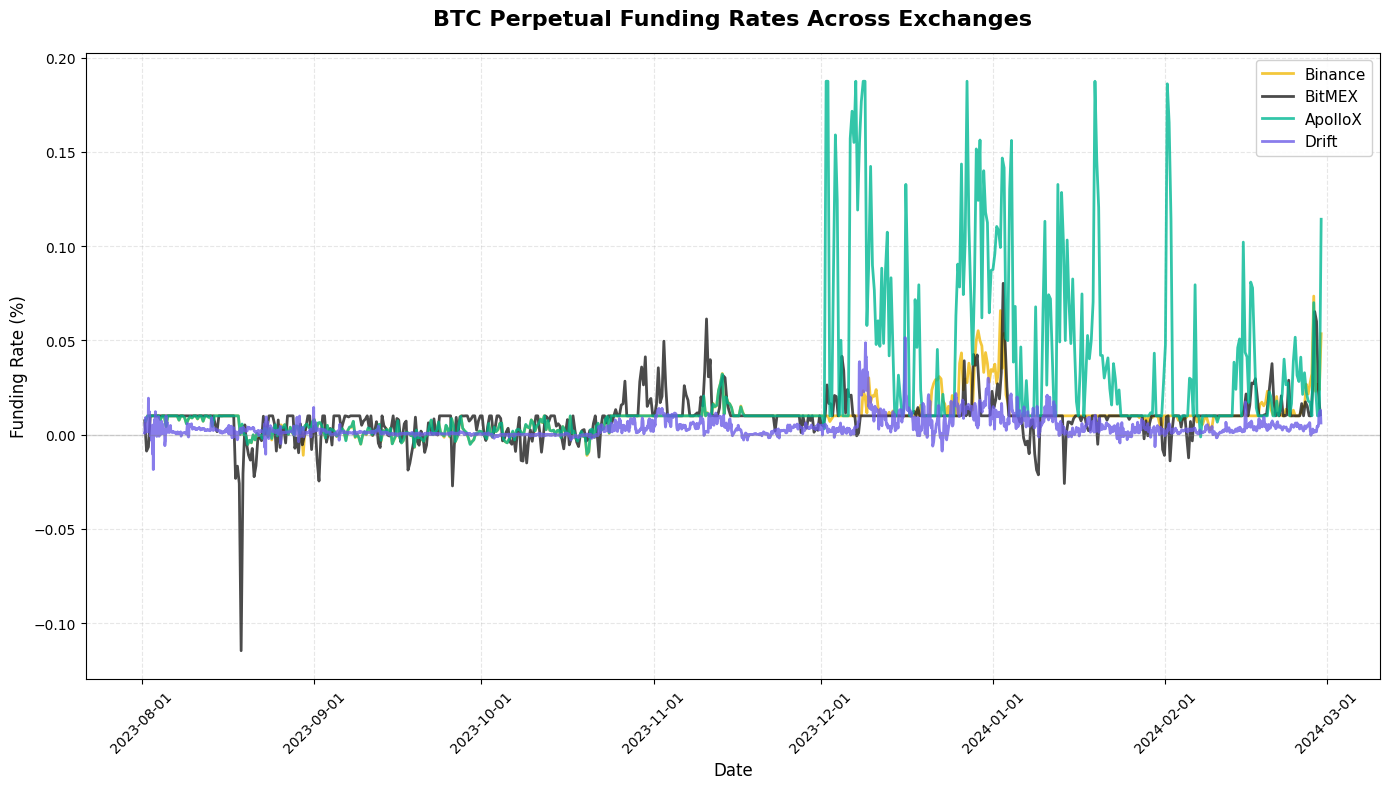

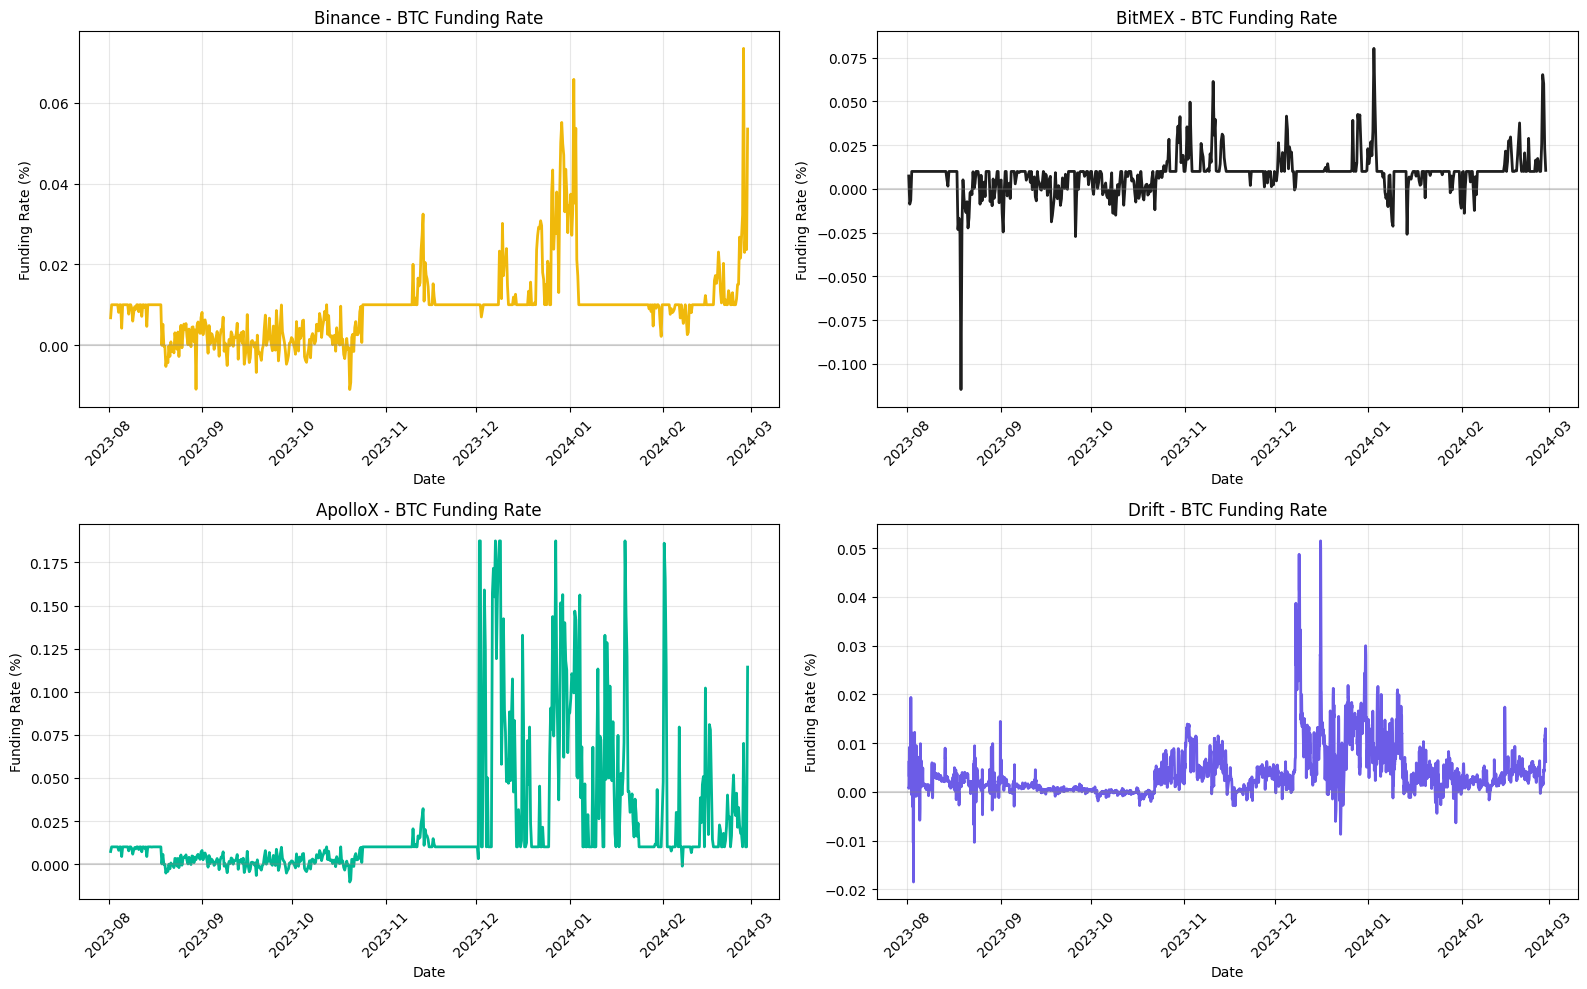

In [4]:
# Create a figure with subplots
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors and styles for each exchange
exchange_styles = {
    'binance': {'color': '#f0b90b', 'label': 'Binance', 'linewidth': 2},
    'bitmex': {'color': '#1e1e1e', 'label': 'BitMEX', 'linewidth': 2},
    'apollox': {'color': '#00b894', 'label': 'ApolloX', 'linewidth': 2},
    'drift': {'color': '#6c5ce7', 'label': 'Drift', 'linewidth': 2}
}

# Filter data for BTC markets only
btc_exchanges = exchanges_markets[0]  # First dict contains BTC markets

# Plot funding rates for each exchange
for exchange, market in btc_exchanges.items():
    if exchange in data_df_map and market in data_df_map[exchange]:
        data_df = data_df_map[exchange][market]
        
        # Filter data within the common time range
        mask = (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
        filtered_data = data_df[mask].copy()
        
        if not filtered_data.empty:
            # Convert timestamp to datetime for plotting
            filtered_data['datetime'] = filtered_data['timestamp'].apply(
                lambda x: datetime.fromtimestamp(x)
            )
            
            # Plot funding rate
            style = exchange_styles.get(exchange, {'color': None, 'label': exchange, 'linewidth': 2})
            ax.plot(
                filtered_data['datetime'], 
                filtered_data['funding_rate'] * 100,  # Convert to percentage
                color=style['color'],
                label=style['label'],
                linewidth=style['linewidth'],
                alpha=0.8
            )

# Customize the plot
ax.set_title('BTC Perpetual Funding Rates Across Exchanges', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Funding Rate (%)', fontsize=12)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Add zero line for reference
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)

# Add some padding
plt.tight_layout()

# Show the plot
plt.show()

# Alternative: Create a figure with subplots for each exchange (if you want to see them separately too)
fig2, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (exchange, market) in enumerate(btc_exchanges.items()):
    if idx >= len(axes):
        break
        
    if exchange in data_df_map and market in data_df_map[exchange]:
        data_df = data_df_map[exchange][market]
        
        # Filter data within the common time range
        mask = (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
        filtered_data = data_df[mask].copy()
        
        if not filtered_data.empty:
            filtered_data['datetime'] = filtered_data['timestamp'].apply(
                lambda x: datetime.fromtimestamp(x)
            )
            
            style = exchange_styles.get(exchange, {'color': None, 'label': exchange})
            ax = axes[idx]
            ax.plot(
                filtered_data['datetime'], 
                filtered_data['funding_rate'] * 100,
                color=style['color'],
                linewidth=2
            )
            
            ax.set_title(f'{style["label"]} - BTC Funding Rate', fontsize=12)
            ax.set_xlabel('Date')
            ax.set_ylabel('Funding Rate (%)')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

        data_df = data_df[
            (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
        ]

        data_df = data_df.sort_values(by='datetime', ascending=True)
        data_df = data_df.reset_index(drop=True) # resetting index is crucial for the backtest function to work correctly because Integer-based indexing is used in get_backtest_result

        result_df = get_backtest_result(data_df, leverage)
        
        if exchange not in results:
            results[exchange] = {}
            
        results[exchange][market] = result_df

# Results are store in 'results' and 'hodl_df' variables

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

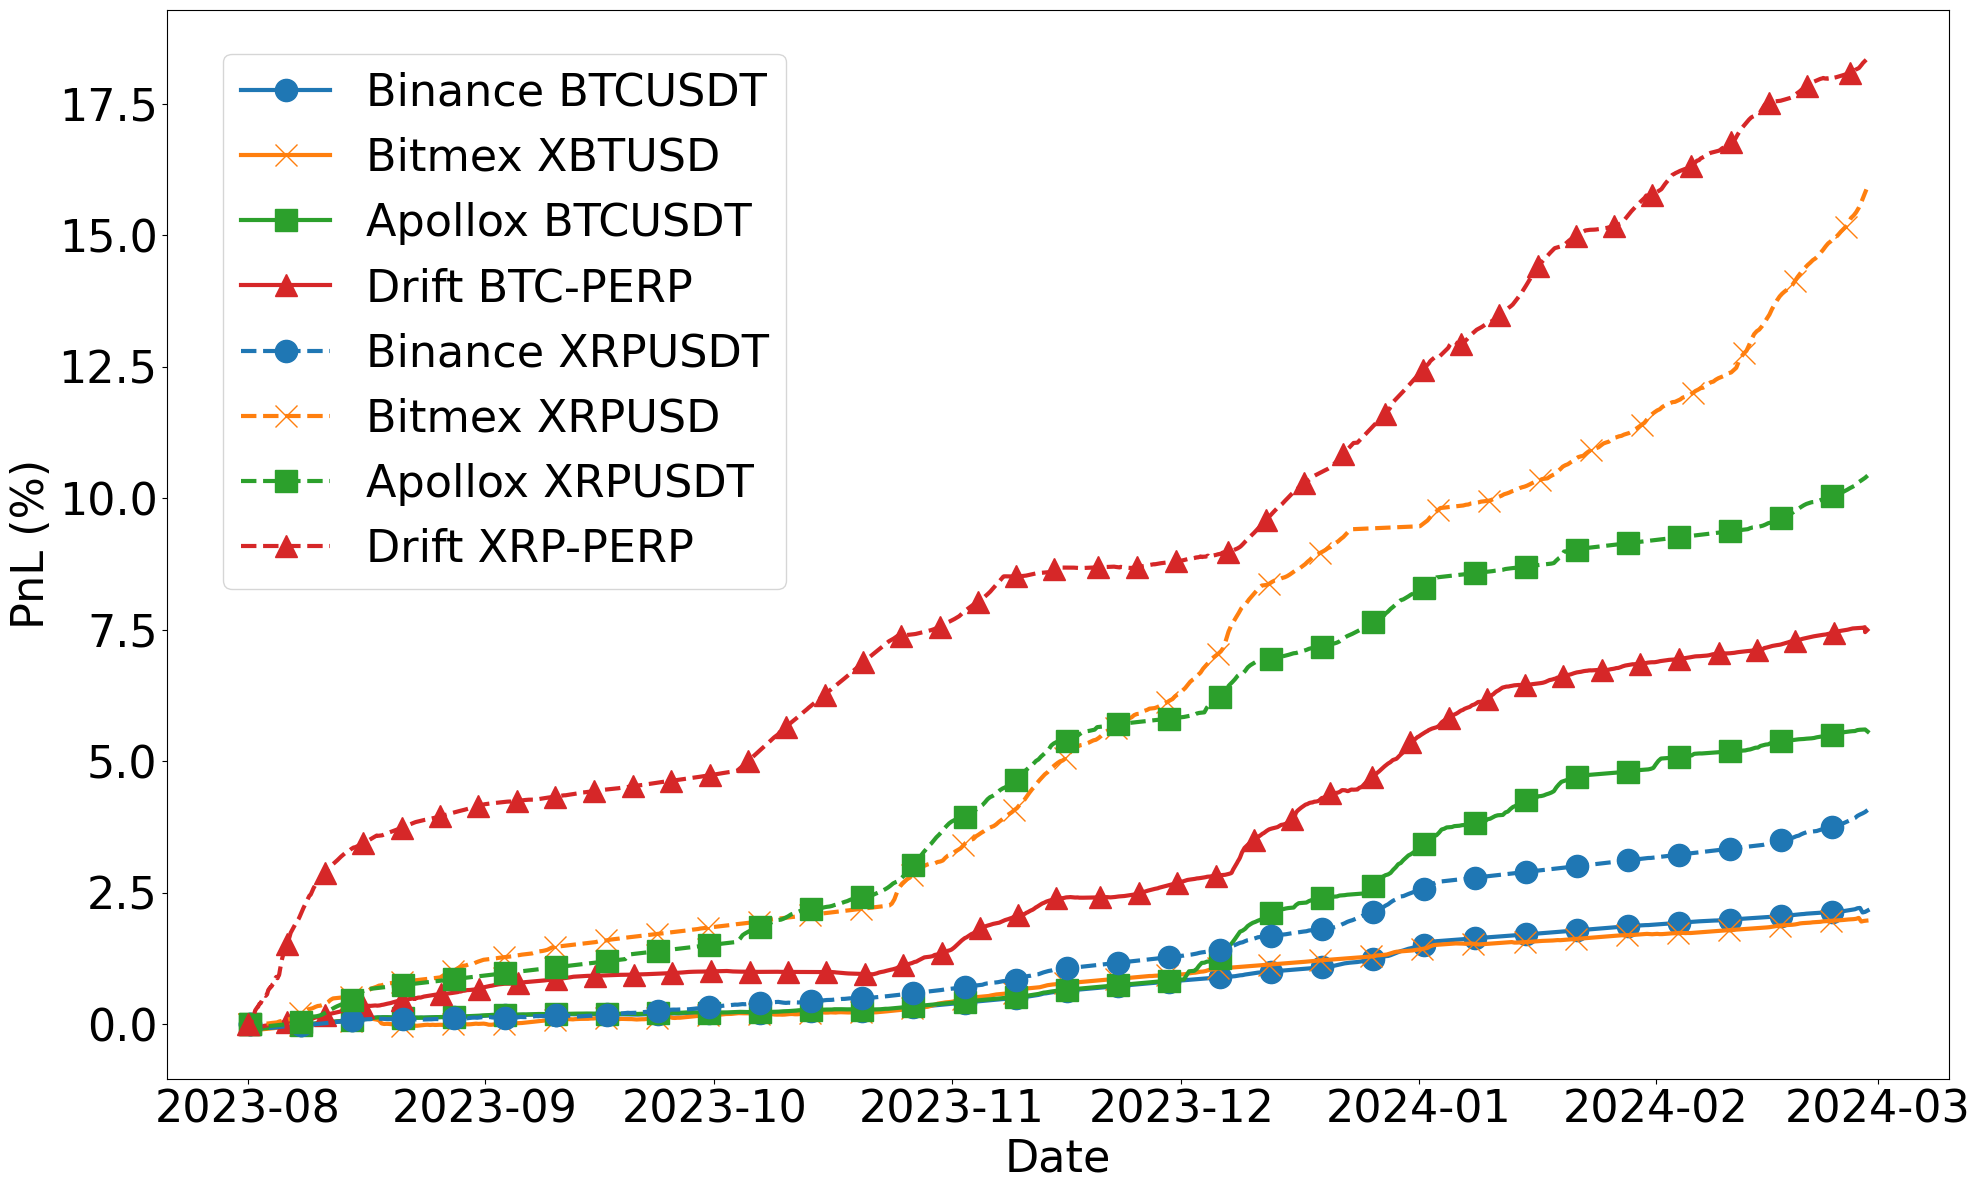

In [6]:
# Plot funding rate arb PNL only

line_styles = {
    "BTCUSDT": "-",
    "XBTUSD": "-",
    "BTCUSDT": "-",
    "BTC-PERP": "-",
    "XRPUSDT": "--",
    "XRPUSD": "--",
    "XRPUSDT": "--",
    "XRP-PERP": "--"
}

markers = {"binance": "o", "apollox": "s", "bitmex": "x", "drift": "^"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 120}
color_map = {"binance": "C0", "bitmex": "C1", "apollox": "C2", "drift": "C3"}

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        result_df = results[exchange][market]
        line,  = ax.plot(
            result_df["datetime"],
            result_df["final_pnl"] * 100,
            label=f"{exchange.capitalize()} {market}",
            color=color_map[exchange],
            ms=16,
            marker=markers[exchange],
            markevery=mark_every[exchange],
            linestyle=line_styles[market],
            linewidth=3
        )
        filename = f"{exchange}_{market}_results.csv"
        # Save to CSV
        result_df.to_csv(f'./output/{filename}', index=False)
        
# Chart settings
lines, labels = ax.get_legend_handles_labels()
plt.xlabel("Date", fontsize=32)
plt.ylabel("PnL (%)", fontsize=32)
ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.36, 0.98), fontsize=32)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig(f'./figs/pnl_analysis.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [5]:

pnl = {}
max_dd = {}
sharpe = {}

# Aggregate data
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        result_df = results[exchange][market]
        key = f"{exchange}_{market}"
        pnl[key] = result_df['final_pnl'].iloc[-1]
        max_dd[key] = max_drawdown(result_df['final_pnl'])
        sharpe[key] = sharpe_ratio(result_df['final_pnl'])
        
    
sorted_pnl = sorted(pnl.items(), key=lambda x:x[1])
print("Sorted PNL: ")
for item in sorted_pnl:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")

print("====")
sorted_max_dd = sorted(max_dd.items(), key=lambda x:x[1])
print("Sorted Max Drawdown: ")
for item in sorted_max_dd:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")
    
print("====")
sorted_sharpe_ratio = sorted(sharpe.items(), key=lambda x:x[1])
print("Sorted Sharpe Ratio: ")
for item in sorted_sharpe_ratio:
    print(f"{item[0]} -> {item[1]:.2f}")
    
print("====")
def average(list_tuple):
    data_arr = [item[1] for item in list_tuple]
    return sum(data_arr) / len(data_arr)

print(f"Average PNL: {average(sorted_pnl) * 100:.2f}%")
print(f"Average DD: {average(sorted_max_dd) * 100:.2f}%")
print(f"Average Sharpe: {average(sorted_sharpe_ratio):.2f}")

TypeError: sharpe_ratio() missing 1 required positional argument: 'invest_return'